# 🚀 Motion Classifier Tutorial: Data Labeling with Snorkel

In this tutorial, we will walk through the process of using Snorkel to build a training set for classifying court docket entries as MOTION or NOT MOTION.

Resources:
* For an overview of Snorkel, visit [snorkel.org](https://snorkel.org)
* You can also check out the [Snorkel API documentation](https://snorkel.readthedocs.io/)
* For some real-world applications, check out [Snorkel Applications](https://www.snorkel.org/resources/)

The goal of this tutorial is to illustrate some basic components and concepts of Snorkel in a simple way, but also to dive into a process of iteratively developing a text classifier in Snorkel.

**The goal of this research is to design an interaction for a non-technical, domain expert to quickly label a dataset.**

To achieve this goal, we start with a basic task: *binary text classification* of court docket entries as MOTION or NOT MOTION.

We have access to a large amount of *unlabeled data* (about 1 300 000 samples) in the form of court docket entries with some metadata. We also have access to about *7000 labeled samples*.

In order to train a classifier, we need to label our data, but doing so by hand for real world applications can often be prohibitively slow and expensive.

In these cases, we can turn to a _weak supervision_ approach, using **_labeling functions (LFs)_** in Snorkel: noisy, programmatic rules and heuristics that assign labels to unlabeled training data.

We'll dive into the Snorkel API and how we write labeling functions later in this tutorial, but as an example, we can write an LF that labels data points with `"MOTION to"` in the docket entry text as MOTION since many motions contain `"MOTION to"`:

```python
from snorkel.labeling import labeling_function

@labeling_function()
def lf_contains_link(x):
    # Return a label of MOTION if "MOTION to" in comment text, otherwise ABSTAIN
    return MOTION if "motion to" in x.text.lower() else ABSTAIN
```

The tutorial is divided into four parts:
1. **Loading Data**: We load a US courts docket entries dataset, originally used in ["From data to information: automating data science to explore the U.S. court system"](https://dl.acm.org/doi/abs/10.1145/3462757.3466100).

2. **Writing Labeling Functions**: We write Python programs that take as input a data point and assign labels (or abstain) using heuristics, pattern matching, and third-party models.

3. **Combining Labeling Function Outputs with the Label Model**: We model the outputs of the labeling functions over the training set using a Snorkel's, theoretically-grounded modeling approach, ["Data Programming:
Creating Large Training Sets, Quickly"](https://arxiv.org/abs/1605.07723), which estimates the accuracies and correlations of the labeling functions using only their agreements and disagreements, and then uses this to reweight and combine their outputs, which we then use as _probabilistic_ training labels.

4. **Training a Classifier**: We train a classifier that can predict labels for *any* court docket entry (not just the ones labeled by the labeling functions) using the probabilistic training labels from step 3.

In future work, we'll consider *multiclass text classification* of court docket entries as MOTION type. Multiclass text classication is an important problem to work on because we need to define a process that is robust to *concept drift*. The set of classes could expand or change over time, and we do not want to start the labeling process from scratch.

**Note that this process requires programming, but out target user is not technical.**

If we are successful in these text classification tasks, we will consider  solutions to help non-technical workers label the data without programming themselves. Solutions include:
1. Function building interfaces, as seen on Snorkel Flow.
2. Distant supervision: leveraging external knowledge bases. 
3. Mapping natural language inputs to labeling functions. We can use the [BabbleLabbleFramework](https://github.com/HazyResearch/babble) to parse Snorkel Labeling Functions

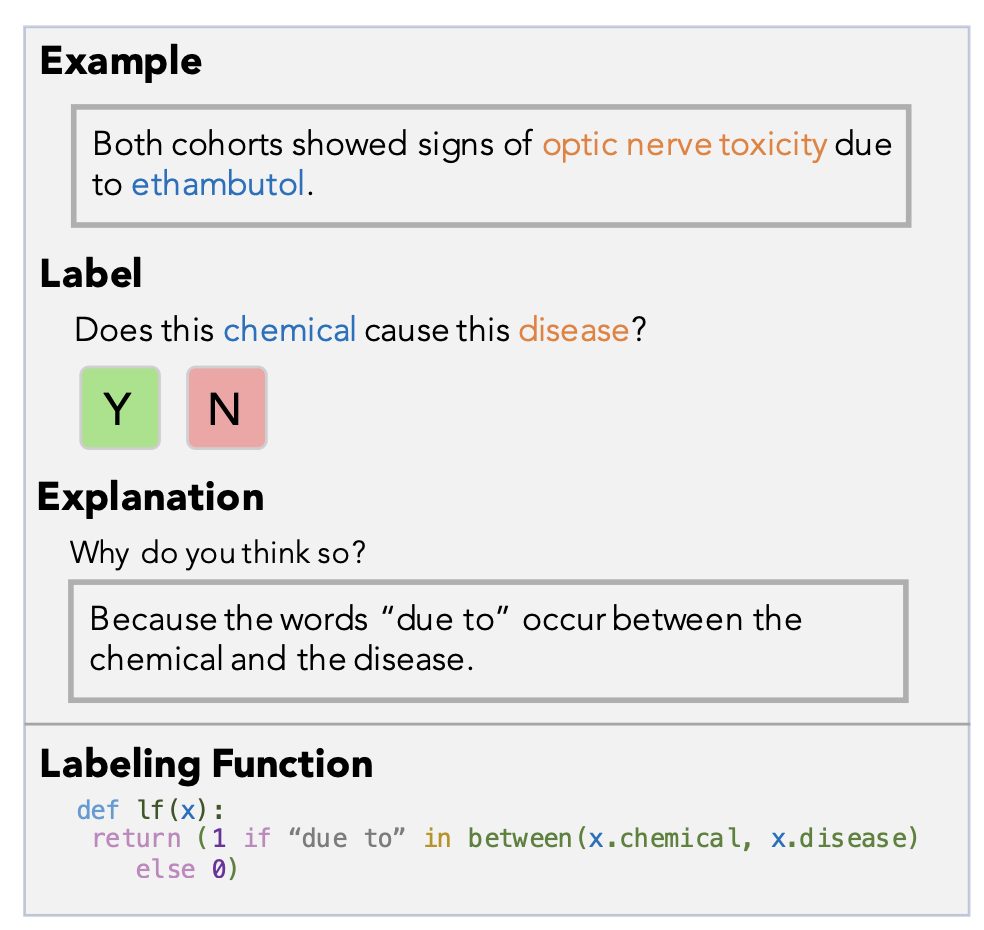

4. Interfaces/systems where users can provide annotations, which are then converted to labeling functions. An example of such a technology is [Ruler: Data Programming by Demonstration for Document Labeling](https://aclanthology.org/2020.findings-emnlp.181/)

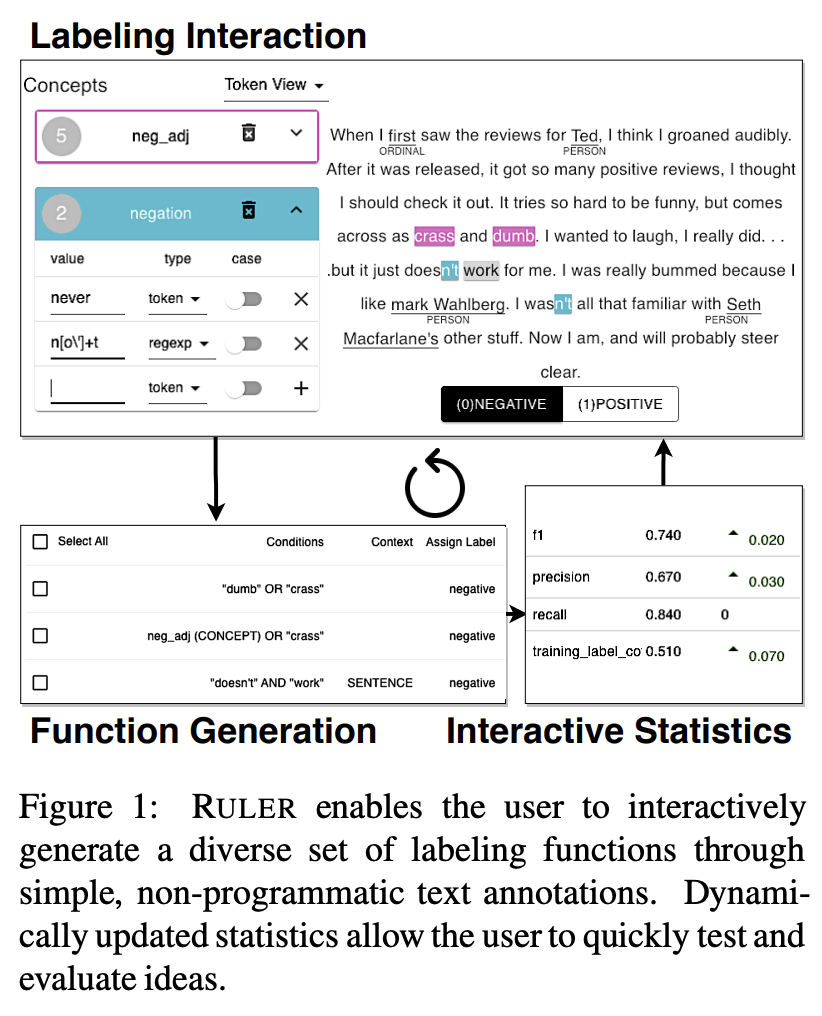

We are also interested in optimizations of the interaction between the user and the system. So important questions, raised by [Mallinar et al. 2019](https://arxiv.org/pdf/1812.06176.pdf):
1. How do we provide guidance to users to create effective labeling functions? From [Mallinar et al. 2019](https://arxiv.org/pdf/1812.06176.pdf), users desire guidance on how to optimize for precision, coverage, and bias between positive/negative examples in creating functions.
2. How do we support data exploration? Users may be domain experts, but that does not mean they are familiar with the corpus.
3. How do we provide fast feedback and progress tracking? Users desire to see how each query or labeling function impacts the results with immediate feedback. The feedback can help users actively adjust the labeling functions they provided. Systems that require training on many classes stress the need to know when it's time to move on to a diferent class.
4. Support evolving classes.

Other questions:
1. How do we minimize the number of samples the user has to see or label?
2. Can we use active learning, uncertainty sampling, or other techniques to surface *valuable examples*? [Active WeaSuL: Improving Weak Supervision with Active Learning](https://github.com/SamanthaBiegel/ActiveWeaSuL) provides some ideas on this.
3. Can a system learn or define heuristics for data labeling? For instance in [Interactive Weak Supervision: Learning Useful Heuristics for Data Labeling](https://github.com/benbo/interactive-weak-supervision)

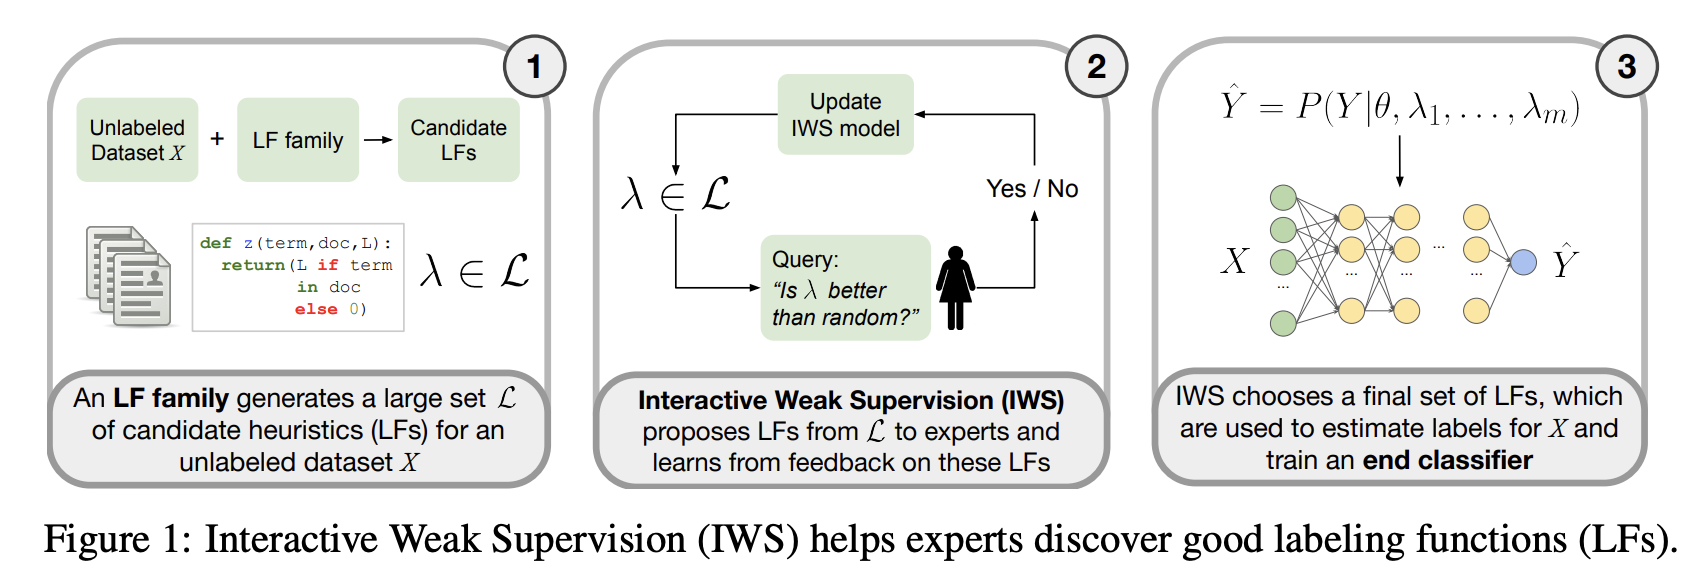

Note: For 3. how do we come up with the LF function family? Can it come from [Reef](https://github.com/HazyResearch/reef)? 

# The code starts here

## Imports

In [186]:
import re
import numpy as np
import pandas as pd

import metal
import snorkel
from snorkel.labeling import labeling_function, PandasLFApplier, LFAnalysis
from snorkel.labeling.model.label_model import LabelModel
from snorkel.labeling.model.baselines import MajorityClassVoter
from snorkel.labeling.model.baselines import MajorityLabelVoter

import spacy
from spacy import displacy
from spacy.lang.en import English

from sklearn.model_selection import train_test_split

Set `DISPLAY_FULL_TEXT` to `True` if you want to see the full docket entry texts.

In [135]:
DISPLAY_FULL_TEXT = True
pd.set_option('display.max_colwidth', 0 if DISPLAY_FULL_TEXT else 50)

## 1. Loading Data

In [136]:
data_dir = 'datasets/court_docket_entries'

We have 5 files:
1. `motionEntries.csv`: 1 300 000 docket entries, almost all unlabeled, with `text` and `id`
2. `tags.csv`: a mapping from `tag_id` to `label`, which is `motion class`
3. `thingy.csv`: looks like we can ignore this
4. `users.csv`: the annotators
5. `usertags`: 7 000 annotations for the docket entries with `docket_entry_id` and `tag_id`

In [137]:
# thingy = pd.read_csv(f"{data_dir}/thingy.csv")
# users = pd.read_csv(f"{data_dir}/users.csv")

We load the data from `motionEntries.csv`, `tags.csv`, and `usertags.csv`, rename some columns, and merge the data into one dataframe.

In [138]:
entries = pd.read_csv(f"{data_dir}/motionEntries.csv")
entries_columns = ['id', 'text', 'case_id', 'sealed', 'jurisdiction']
entries = entries[entries_columns].rename(columns={"id": "docket_entry_id"})

In [139]:
print(f"We have {entries.shape[0]} docket entries")

We have 1377516 docket entries


In [140]:
tags = pd.read_csv(f"{data_dir}/tags.csv")
# tags_columns = ['id', 'label', 'count']
tags_columns = ['id', 'label']
tags = tags[tags_columns].rename(columns={'id': 'tag_id'})
tags['motion'] = tags['tag_id'].apply(lambda x: int(x not in [26, 28]))

In [141]:
usertags = pd.read_csv(f"{data_dir}/usertags.csv")
usertags_columns = ['id', 'docket_entry_id', 'tag_id']
usertags = usertags[usertags_columns].rename(columns={'id': 'usertags_id'})

In [142]:
print(f"We have {usertags.shape[0]} labeled docket entries")

We have 7990 labeled docket entries


We merge the dataframes to get the text and motion label for each docket entry. Also, we remove the samples with label 'SKIP' because we don't know what to do with them.

In [143]:
labels = pd.merge(usertags, tags, on='tag_id')
labeled_motions = pd.merge(labels, entries, on='docket_entry_id')
labeled_motions = labeled_motions[labeled_motions['label'] != 'SKIP']
print(f"We have {labeled_motions.shape[0]} labeled docket entries when we remove SKIP.")

We have 6610 labeled docket entries when we remove SKIP.


Let's now create our dataset of labeled functions. We have 6610 samples if we remove the docket entries with label 'SKIP'.

In [144]:
keep_columns = ['docket_entry_id', 'motion', 'text']
lf_set = labeled_motions[keep_columns]

In [145]:
lf_set.head()

,docket_entry_id,motion,text
1,3112,1,"MOTION (Oral) by USA for excludable time from 9/18/07 through and including 10/04/07 pursuant to 18 USC 3161(h)(1) & (h)((1)(F) as to Demario Flemming (jmm-r, ) (Entered: 09/20/2007)"
4,9574,0,"DECLARATION of Aref Abdellatif regarding order on motion to compel,,,,,,, text entry,,,,,, 186 (Schaller, Rachel) (Entered: 08/19/2019)"
5,9574,0,"DECLARATION of Aref Abdellatif regarding order on motion to compel,,,,,,, text entry,,,,,, 186 (Schaller, Rachel) (Entered: 08/19/2019)"
9,4068,1,"MOTION by Tori Frederick DEFENDANT'S MOTION FOR PRETRIAL RELEASE (Rodriguez, Sergio) (Entered: 02/15/2008)"
11,833,1,"(Unopposed) NOTICE of Motion by Kathryn Ann Kelly for presentment of motion for leave to file excess pages 44 before Honorable M. David Weisman on 10/26/2017 at 09:15 AM. (Kelly, Kathryn) (Entered: 10/23/2017)"


Create train, dev, test split: 60/20/20.

In [146]:
df_train, df_test = train_test_split(lf_set, stratify=lf_set['motion'], test_size=0.4)
df_val, df_test = train_test_split(df_test, stratify=df_test['motion'], test_size=0.5)

In [147]:
def get_n_samples(df, n):
    return df.sample(n)

Let's set out voting values. Recall that the classification task is MOTION or NOT MOTION.

In [148]:
# Set voting values.
ABSTAIN = -1 
MOTION = 1 
NOT_MOTION = 0

In [224]:
get_n_samples(df_train, 10)

,docket_entry_id,motion,text
5328,938,1,"MOTION by Counter Claimant Republic Bank of Chicago to appoint receiver for Global Cash Network, Inc. (Attachments: # 1 Exhibit Resume - Coorsh)(Freud, Edward) (Entered: 06/03/2016)"
1790,13040,1,"First MOTION for Extension of Time to File Response/Reply Reply Brief by Plaintiff Christina M Tucker. (Shull, Joseph) (Entered: 09/14/2016)"
6270,12581,1,"MOTION to Continue by Jesus Montes-Perez. (O'Malley - FCD, Thomas) (Entered: 11/10/2016)"
6289,7034,1,"MOTION by James M Vani to continue sentencing (Beal, John) (Entered: 11/18/2014)"
3662,16172,1,"MOTION to Dismiss by Defendant Wal-Mart Stores East, LP. (Pfleging, Lesley) (Entered: 06/14/2018)"
1401,5111,1,"MOTION by Plaintiff Jerome Tate for extension of time to file report of parties planning conference and proposed scheduling order (Toppel, Neil) (Entered: 03/25/2008)"
2085,13434,1,"First MOTION for Extension of Time to File Response/Reply to Presentence Report by Ari Weichman. (Padula, William) (Entered: 01/30/2017)"
3257,8597,1,"MOTION by counsel for Plaintiff Wayne Guider to withdraw as attorney and to decline appointment (Hebeisen, Keith) (Entered: 02/15/2012)"
2822,12068,1,"MOTION for Leave to Proceed in forma pauperis (Prisoner Trust Account Ledger attached) by Plaintiff Clifton Massey. (Myers, Christopher) (Entered: 04/27/2016)"
459,15097,0,"STATUS CONFERENCE held on 11/15/2018 before Judge Robert L Miller, Jr. Pla appeared by atty Brenda Fulmer. Dft appeared by atty John Winter, Erin Hanig. Topics discussed included status of discovery in Groups 6 and 7 and pending motions. Next status conference set for Wednesday, January 9, 2019 at 1:15 p.m. (EST) in US District Court - South Bend before Judge Robert L Miller Jr. (Court Reporter D. Bonk.) Associated Cases: 3:12-md-02391-RLM-MGG et al.(jld) Modified on 12/13/2018 to correct date of hearing (jld). (Entered: 11/19/2018)"


In [200]:
# Key words for explicit mention of a motion
"""
MOTION_MENTIONS = r"\b(motion by|motion (oral) by|motion for|motion to)"
def lf_regex_mention_of_motion(x):
    return MOTION if re.search(MOTION_MENTIONS, x.text) else ABSTAIN

# Key words for explicit mention of a something other than a motion
OTHER = r"\b(JUDGEMENT (Sentencing Order)|FINAL PRETRIAL CONFERENCE)"
def explicit_mention_of_other_term(text):
    return NEGATIVE if re.search(OTHER, text) else ABSTAIN
"""
# Key words for explicit mention of a motion
@labeling_function()
def lf_motion_of(x):
    return MOTION if "motion of" in x.text.lower() else ABSTAIN

@labeling_function()
def lf_motion_by(x):
    return MOTION if "motion by" in x.text.lower() else ABSTAIN

@labeling_function()
def lf_motion_to(x):
    return MOTION if "motion to" in x.text.lower() else ABSTAIN

@labeling_function()
def lf_motion_oral_by(x):
    return MOTION if "motion (oral) by" in x.text.lower() else ABSTAIN

# Key words for explicit mention of a something other than a motion
@labeling_function()
def lf_judgement(x):
    return NOT_MOTION if "judgement (sentencing order)" in x.text.lower() else ABSTAIN

@labeling_function()
def lf_final_pretrial_conference(x):
    return NOT_MOTION if "final pretrial conference" in x.text.lower() else ABSTAIN

@labeling_function()
def lf_denying_motion(x):
    return NOT_MOTION if "denying motion" in x.text.lower() else ABSTAIN

MOTION_MENTIONS = r"\b(motion by|motion (oral) by|motion for|motion to)"
@labeling_function()
def lf_regex_mention_of_motion(x):
    return MOTION if re.search(MOTION_MENTIONS, x.text) else ABSTAIN

@labeling_function()
def lf_first_word_motion(x):
    """Tokenizes the text to check if first word is motion."""
    _first_token = tokenizer(x.text.lower())[0]
    return MOTION if "motion" == _first_token.text else ABSTAIN

@labeling_function()
def lf_motion_mentioned_later(x):
    """Tokenizes the text to check if first word is motion."""
    tokens = tokenizer(x.text.lower())
    texts = [token.text for token in tokens]
    # Motion is mentioned somewhere in the middle of the docket entry
    # and Motion is not mentioned at the start
    condition = "motion" in texts[2:] and "motion" not in texts[:1]
    return NOT_MOTION if condition else ABSTAIN

@labeling_function()
def lf_motion_early(x):
    """Tokenizes the text to check if motion is mentioned in first 5 words"""
    tokens = tokenizer(x.text.lower())
    texts = [token.text for token in tokens]
    # Motion is mentioned somewhere in the middle of the docket entry
    # and Motion is not mentioned at the start
    condition = "motion" in texts[:5] and "motion" not in texts[6:]
    return MOTION if condition else ABSTAIN

@labeling_function()
def lf_notice_of_motion(x):
    """NOTICE of motion"""
    return NOT_MOTION if 'notice of motion' in x.text else ABSTAIN

In [201]:
tokens = tokenizer("Motion to dismiss.".lower())[0]
type(tokens.text)

str

In [152]:
# nlp = spacy.load("en_core_web_sm")
# doc = nlp("Motion to dismiss.")
# tokens = tokenizer("Motion to dismiss.")
# displacy.render(doc, style="dep")

In [202]:
lfs = [
    lf_motion_of,
    lf_motion_by,
    lf_motion_to,
    lf_motion_oral_by,
    lf_judgement,
    lf_final_pretrial_conference,
    lf_denying_motion,
    # lf_regex_mention_of_motion,
    lf_first_word_motion,
    lf_motion_mentioned_later,
    lf_motion_early,
    lf_notice_of_motion
]

applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train)
L_val = applier.apply(df=df_val)
L_test = applier.apply(df=df_test)

/Users/benigerisimon/opt/miniconda3/envs/machine-teaching/lib/python3.8/site-packages/tqdm/std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 1322/1322 [00:00<00:00, 7542.99it/s]


In [203]:
t = "MOTION for Extension of Time to File Magistrate Consent Forms (Agreed Motion) by Plaintiff Northern Indiana Public Service Company. (Attachments: # 1 Proposed Order)(Neumann, Matthew) (Entered: 08/10/2017"

In [204]:
tokens = tokenizer(t.lower())
texts = [token.text for token in tokens]
# Motion is mentioned somewhere in the middle of the docket entry
# and Motion is not mentioned at the start
condition = "motion" in texts[2:] and "motion" not in texts[:1]

In [205]:
condition

False

In [206]:
L_train

array([[-1,  1, -1, ..., -1,  1, -1],
       [-1, -1,  1, ...,  0, -1, -1],
       [-1,  1, -1, ..., -1,  1, -1],
       ...,
       [-1,  1, -1, ..., -1,  1, -1],
       [-1,  1, -1, ...,  0,  1, -1],
       [-1,  1, -1, ..., -1,  1, -1]])

In [207]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary(Y=df_train['motion'].to_numpy())

/Users/benigerisimon/opt/miniconda3/envs/machine-teaching/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[-1  0  1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
lf_motion_of,0,[1],0.007060,0.007060,0.005547,5,23,0.178571
lf_motion_by,1,[1],0.599849,0.599849,0.049168,2209,170,0.928541
lf_motion_to,2,[1],0.220877,0.220877,0.096067,580,296,0.662100
lf_motion_oral_by,3,[1],0.014120,0.014120,0.000000,56,0,1.000000
lf_judgement,4,[],0.000000,0.000000,0.000000,0,0,0.000000
lf_final_pretrial_conference,5,[0],0.011851,0.005295,0.002269,47,0,1.000000
lf_denying_motion,6,[0],0.000756,0.000756,0.000756,3,0,1.000000
lf_first_word_motion,7,[1],0.579425,0.578164,0.001765,2284,14,0.993908
lf_motion_mentioned_later,8,[0],0.223651,0.143469,0.140444,725,162,0.817362
lf_motion_early,9,[1],0.649269,0.563792,0.023197,2518,57,0.977864


Lots of statistics about labeling functions — like coverage — are useful when building any Snorkel application. So Snorkel provides tooling for common LF analyses using the LFAnalysis utility. We report the following summary statistics for multiple LFs at once:

* Polarity: The set of unique labels this LF outputs (excluding abstains)
* Coverage: The fraction of the dataset the LF labels
* Overlaps: The fraction of the dataset where this LF and at least one other LF label
* Conflicts: The fraction of the dataset where this LF and at least one other LF label and disagree
* Correct: The number of data points this LF labels correctly (if gold labels are provided)
* Incorrect: The number of data points this LF labels incorrectly (if gold labels are provided)
* Empirical Accuracy: The empirical accuracy of this LF (if gold labels are provided)

We see that our labeling functions vary in coverage, how much they overlap/conflict with one another, and almost certainly their accuracies as well. We can view a histogram of how many LF labels the data points in our train set have to get an idea of our total coverage.

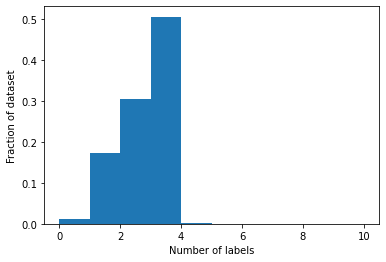

In [208]:
import matplotlib.pyplot as plt

%matplotlib inline


def plot_label_frequency(L):
    plt.hist((L != ABSTAIN).sum(axis=1), density=True, bins=range(L.shape[1]))
    plt.xlabel("Number of labels")
    plt.ylabel("Fraction of dataset")
    plt.show()


plot_label_frequency(L_train)

We see that over less than 1/10 of our `train` dataset data points have 0 or fewer labels from LFs. The labels we do have can be used to train a classifier over the comment text directly, allowing this final machine learning model to generalize beyond what our labeling functions labeling.

Our goal is now to convert the labels from our LFs into a single noise-aware probabilistic (or confidence-weighted) label per data point. 

A simple baseline for doing this is to take the majority vote on a per-data point basis: if more LFs voted MOTION than NOT_MOTION, label it MOTION (and vice versa). We can test this with the `MajorityLabelVoter` baseline model.

In [209]:
majority_model = MajorityLabelVoter()
preds_train_majority_model = majority_model.predict(L=L_train)

In [210]:
label_model = LabelModel(cardinality=2, device='cpu', verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)

INFO:root:Computing O...
INFO:root:Estimating \mu...
  0%|          | 0/500 [00:00<?, ?epoch/s]INFO:root:[0 epochs]: TRAIN:[loss=0.885]
INFO:root:[100 epochs]: TRAIN:[loss=0.008]
 36%|███▌      | 178/500 [00:00<00:00, 1777.00epoch/s]INFO:root:[200 epochs]: TRAIN:[loss=0.008]
INFO:root:[300 epochs]: TRAIN:[loss=0.008]
INFO:root:[400 epochs]: TRAIN:[loss=0.008]
100%|██████████| 500/500 [00:00<00:00, 2174.79epoch/s]
INFO:root:Finished Training


In [211]:
preds_train_label_model = label_model.predict(L=L_train)

**Train accuracy**

In [212]:
majority_acc = majority_model.score(L=L_train, Y=df_train.motion, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_train, Y=df_train.motion, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   90.4%
Label Model Accuracy:     87.4%


**Val accuracy**

In [213]:
majority_acc = majority_model.score(L=L_val, Y=df_val.motion, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_val, Y=df_val.motion, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   90.4%
Label Model Accuracy:     86.4%


**Test accuracy**

In [214]:
majority_acc = majority_model.score(L=L_test, Y=df_test.motion, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_test, Y=df_test.motion, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   90.8%
Label Model Accuracy:     88.0%


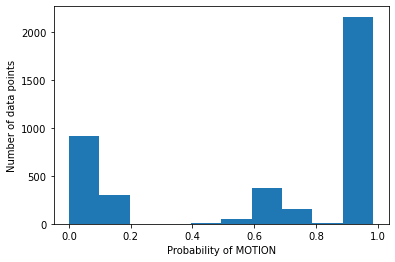

In [215]:
def plot_probabilities_histogram(Y):
    plt.hist(Y, bins=10)
    plt.xlabel("Probability of MOTION")
    plt.ylabel("Number of data points")
    plt.show()


probs_train = label_model.predict_proba(L=L_train)
plot_probabilities_histogram(probs_train[:, MOTION])

In [216]:
from snorkel.labeling import filter_unlabeled_dataframe

df_train_filtered, probs_train_filtered = filter_unlabeled_dataframe(
    X=df_train, y=probs_train, L=L_train
)

In [217]:
df_train_filtered

,docket_entry_id,motion,text
3281,19760,1,"MOTION by Attorney Sindhu Daniel to withdraw as attorney for Anthony Cirrincione, Sylvia Cirrincione. No party information provided (Daniel, Sindhu) (Entered: 05/20/2016)"
1124,16381,0,"AMENDED PETITION for Writ of Habeas Corpus, filed by Roger Pringle. (Attachments: # 1 Exhibits, # 2 Proposed Summons, # 3 USM 285 Form)(nae) *efiling stamp is located on motion to appoint counsel DE 44 * (Entered: 02/07/2017)"
2441,9757,1,"MOTION by Defendants Thomas Dart, Superintendent Martinez for protective order regarding HIPAA (Attachments: # 1 Exhibit A, Correspondence to Plaintiff, # 2 Exhibit B, Prisoner Information Sheet, # 3 Exhibit C, Qualified Protective Order)(Nehls, Scott) (Entered: 03/10/2011)"
1012,5871,0,"AGREED NOTICE of Motion by Gail Lynne Reich for presentment of motion for extension of time to file answer, motion for relief 6 before Honorable Virginia M. Kendall on 7/14/2010 at 09:00 AM. (Reich, Gail) (Entered: 07/07/2010)"
5131,1048,1,"MOTION by Defendant Lisa HagadornMotion to Command Federal Deposit Insurance Corporation to Disclose Exempt Records (Attachments: # 1 Exhibit Exhibit 1, # 2 Exhibit Exhibit 2, # 3 Exhibit Exhibit 3, # 4 Exhibit Exhibit 4)(Drury, Scott) (Entered: 06/19/2017)"
...,...,...,...
2616,5759,1,"MOTION for Leave to Appear Pro Hac Vice Filing fee $ 50, receipt number 0752-12543413. (Gillespie, James) (Entered: 11/07/2016)"
5733,17891,1,"MOTION by Defendants Comcast Cable Communications Management, LLC, Comcast Corporation Unopposed Motion to Stay the Court's Ruling on Comcast's Pending Motion to Dismiss (Sweitzer, Stephanie) (Entered: 07/26/2011)"
1316,10570,1,"MOTION by Defendant Enterprise Recovery Systems Inc. for extension of time to complete discovery (Unopposed) (Stevens, James) (Entered: 09/30/2011)"
2918,3441,1,"Counsel MOTION by Plaintiff Victor Santana for leave to appear as Additional Counsel (Lubin, Jonathan) (Entered: 12/18/2009)"


In [218]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1, 5))
X_train = vectorizer.fit_transform(df_train_filtered.text.tolist())
X_test = vectorizer.transform(df_test.text.tolist())

In [219]:
from snorkel.utils import probs_to_preds

preds_train_filtered = probs_to_preds(probs=probs_train_filtered)

In [220]:
from sklearn.linear_model import LogisticRegression

sklearn_model = LogisticRegression(C=1e3, solver="liblinear")
sklearn_model.fit(X=X_train, y=preds_train_filtered)

LogisticRegression(C=1000.0, solver='liblinear')

In [221]:
print(f"Test Accuracy: {sklearn_model.score(X=X_test, y=df_test.motion) * 100:.1f}%")

Test Accuracy: 87.9%
